In [1]:
import pandas as pd
import numpy as np
import zipfile
import matplotlib.pyplot as plt
from sklearn import ensemble
from sklearn import linear_model
from sklearn import svm
%matplotlib inline
from collections import Counter
import sklearn.cross_validation
import math
import time
pd.set_option('display.max_columns', None)
from scipy import stats
from sklearn.linear_model import RandomizedLasso
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
#from sklearn.pls import PLSRegression
import sys
#from pyearth import Earth

In [2]:
filename = "data_sci_snippet.csv.zip"
zf = zipfile.ZipFile(filename, 'r')
print zf.namelist()

['data_sci_snippet.csv']


In [3]:
def time_preprocessing(df, column_name):
    
    times = []
    count = 0
    start = time.time()
    for i in df[column_name]:
        count += 1
        if count % 100000 == 0:
            time_elapsed = time.time() - start
            #print "Count = %r, Time Elapsed = %r" %(count, time_elapsed)
        times.append(time.strptime(i, "%Y-%m-%d"))

    year = []
    month = []
    day = []
    day_of_week = []
    day_in_year = []

    for i in times:
        year.append(i[0])
        month.append(i[1])
        day.append(i[2])
        day_of_week.append(i[6])
        day_in_year.append(i[7])
    df[column_name + ' year'] = year
    df[column_name + ' month'] = month
    df[column_name + ' day'] = day
    df[column_name + ' day_of_week'] = day_of_week
    df[column_name + ' day_in_year'] = day_in_year
    df.drop([column_name], axis=1)
    return df

In [12]:
data = pd.read_csv(zf.open('data_sci_snippet.csv'))

one_hot_columns = ['Pool','ListingStatus','DwellingType']
count = 0
for i in one_hot_columns:
    dummies = pd.get_dummies(data[i])
    for j in dummies:
        data[j] = dummies[j]
        count += 1

data = time_preprocessing(data, 'ListDate')
data = data.dropna()

# Note that we won't have closedate in our test data
# Could still build a model for closing date and use that as a feature
#data = time_preprocessing(data, 'CloseDate')
data = data.drop(['CloseDate'], 1)

# Remove Outliers
data = data[(data['ClosePrice'] > 10000)]
data = data[(data['ClosePrice'] < 500000)]
data = data[(data['ListPrice'] <= 7000000)]

data = data.drop(['Pool', 'ListingStatus', 'DwellingType', 'ListDate', 'PublicRemarks', 'ListDate year'], axis=1)

data['ListPrice'] = np.log(data['ListPrice'])
data['ClosePrice'] = np.log(data['ClosePrice'])
preprocessing_array = []
for i in data:
    if i == 'ClosePrice':
        closeprice_mean = data[i].mean()
        closeprice_std = data[i].std()
    preprocessing_array.append([i, data[i].mean(), data[i].std()])
    data[i] = data[i] - data[i].mean()
    data[i] = data[i]/float(data[i].std())

def unprocess(data, mean = closeprice_mean, std = closeprice_std):
    return np.exp(data*closeprice_std+closeprice_mean)

y = data['ClosePrice']
x = data.drop(['ClosePrice'], 1)
columns = data.columns
x_train, x_test, y_train, y_test = sklearn.cross_validation.train_test_split(
    x, y, test_size=0.02, random_state=14)

data = pd.DataFrame(x_train, columns=columns[:-1])
data['ClosePrice'] = y_train
test_data = pd.DataFrame(x_test, columns=columns[:-1])
test_data['ClosePrice'] = y_test

full = pd.DataFrame()
for_test = pd.DataFrame()
for i in data:
    for j in data:
        if i != 'ClosePrice' and j != 'ClosePrice':
            full[i + '*' + j] = data[i]*data[j]
            for_test[i + '*' + j] = test_data[i]*test_data[j]
full['ClosePrice'] = data['ClosePrice']
correlations = full.corrwith(full['ClosePrice'])
columns = full.columns
for i in range(len(correlations)):
    if abs(list(correlations)[i]) > .3:
        data[columns[i]] = full[columns[i]]
        if columns[i] != 'ClosePrice':
            test_data[columns[i]] = for_test[columns[i]]

stacking_data = data[:len(data)/2]
training_data = data[len(data)/2:]

x_train_stacking = stacking_data[[
                    'LivingArea',
                    'NumBedrooms',
                    'NumBaths',
                    'ExteriorStories',
                    'ListPrice',
                    'GeoLat',
                    'GeoLon',
                    'Both Private & Community',
                    'Private',
                    'Apartment Style/Flat',
                    'Gemini/Twin Home',
                    'Single Family - Detached',
                    'Townhouse',
                'ListPrice*ListPrice',
                 'ListPrice*Single Family - Detached',
                 'Community*None',
                 'None*Community',
                 'Private*Private',
                 'Apartment Style/Flat*Mfg/Mobile Housing',
                 'Apartment Style/Flat*Townhouse',
                 'Mfg/Mobile Housing*Apartment Style/Flat',
                 'Mfg/Mobile Housing*Townhouse',
                 'Single Family - Detached*ListPrice',
                 'Single Family - Detached*Single Family - Detached',
                 'Townhouse*Apartment Style/Flat',
                 'Townhouse*Mfg/Mobile Housing'
               ]]
y_train_stacking = stacking_data['ClosePrice']

x_train_training = training_data[[
                    'LivingArea',
                    'NumBedrooms',
                    'NumBaths',
                    'ExteriorStories',
                    'ListPrice',
                    'GeoLat',
                    'GeoLon',
                    'Both Private & Community',
                    'Private',
                    'Apartment Style/Flat',
                    'Gemini/Twin Home',
                    'Single Family - Detached',
                    'Townhouse',
                     'ListPrice*ListPrice',
                     'ListPrice*Single Family - Detached',
                     'Community*None',
                     'None*Community',
                     'Private*Private',
                     'Apartment Style/Flat*Mfg/Mobile Housing',
                     'Apartment Style/Flat*Townhouse',
                     'Mfg/Mobile Housing*Apartment Style/Flat',
                     'Mfg/Mobile Housing*Townhouse',
                     'Single Family - Detached*ListPrice',
                     'Single Family - Detached*Single Family - Detached',
                     'Townhouse*Apartment Style/Flat',
                     'Townhouse*Mfg/Mobile Housing'
               ]]
y_train_training = training_data['ClosePrice']

x_test_listprice = test_data[[
                    'LivingArea',
                    'NumBedrooms',
                    'NumBaths',
                    'ExteriorStories',
                    'ListPrice',
                    'GeoLat',
                    'GeoLon',
                    'Both Private & Community',
                    'Private',
                    'Apartment Style/Flat',
                    'Gemini/Twin Home',
                    'Single Family - Detached',
                    'Townhouse',
                     'ListPrice*ListPrice',
                     'ListPrice*Single Family - Detached',
                     'Community*None',
                     'None*Community',
                     'Private*Private',
                     'Apartment Style/Flat*Mfg/Mobile Housing',
                     'Apartment Style/Flat*Townhouse',
                     'Mfg/Mobile Housing*Apartment Style/Flat',
                     'Mfg/Mobile Housing*Townhouse',
                     'Single Family - Detached*ListPrice',
                     'Single Family - Detached*Single Family - Detached',
                     'Townhouse*Apartment Style/Flat',
                     'Townhouse*Mfg/Mobile Housing'
                   ]]
y_test = test_data['ClosePrice']

bayesian_ridge = linear_model.Ridge()
bayesian_ridge.fit(x_train_stacking, y_train_stacking)
bayesian_ridge_predictions_test = bayesian_ridge.predict(x_test_listprice)

bayesian_ridge = linear_model.Ridge()
bayesian_ridge.fit(x_train_stacking, y_train_stacking)
bayesian_ridge_predictions_stacking = bayesian_ridge.predict(x_train_training)

x_train_training['Bayesian_Ridge_Predictions'] = bayesian_ridge_predictions_stacking
x_test_listprice['Bayesian_Ridge_Predictions'] = bayesian_ridge_predictions_test

booster = ensemble.GradientBoostingRegressor(n_estimators = 110)
booster.fit(x_train_training, y_train_training)
booster_predictions = booster.predict(x_test_listprice)

forest = ensemble.RandomForestRegressor(n_estimators = 100)
forest.fit(x_train_training, y_train_training)
forest_predictions = booster.predict(x_test_listprice)

median = np.median(abs((unprocess(booster_predictions)+unprocess(forest_predictions))/2.0-unprocess(y_test)))
print "Median = %r" %median

Median = 3280.039948568301


/Users/jeremynixon/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/jeremynixon/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:169: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [75]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

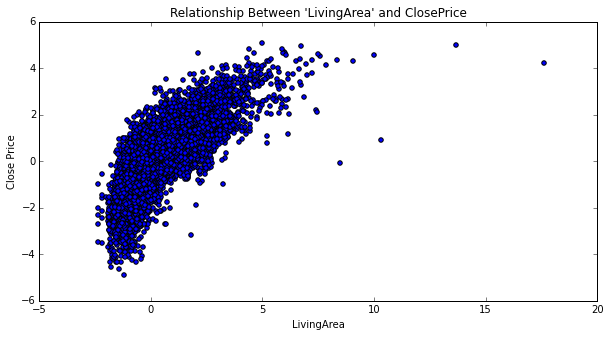

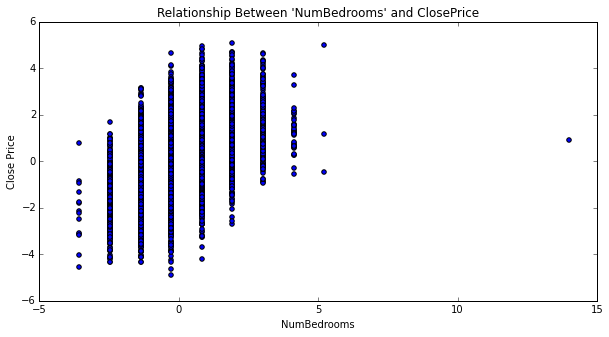

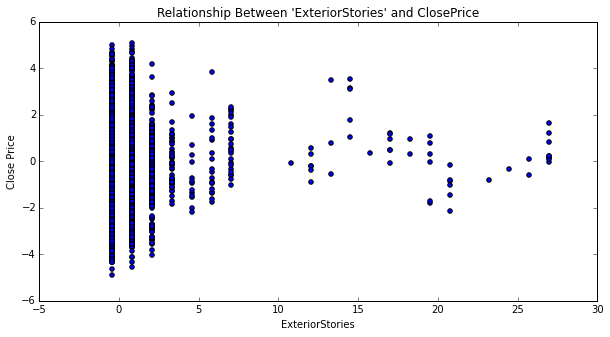

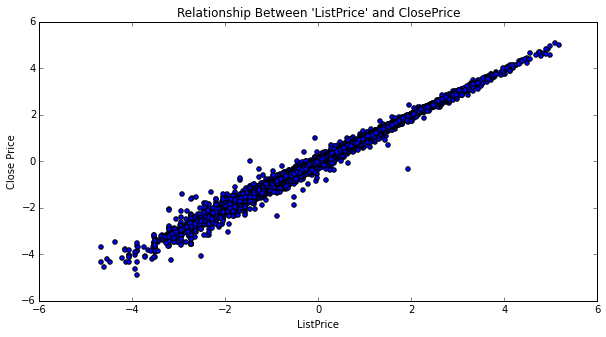

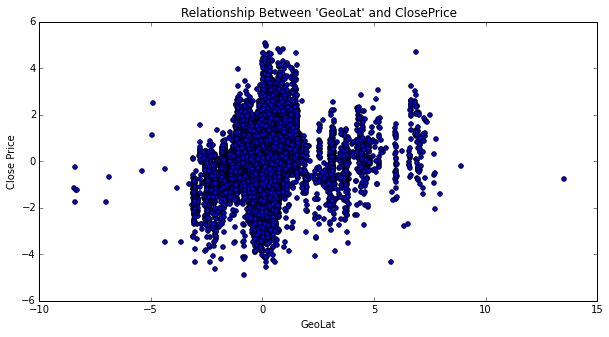

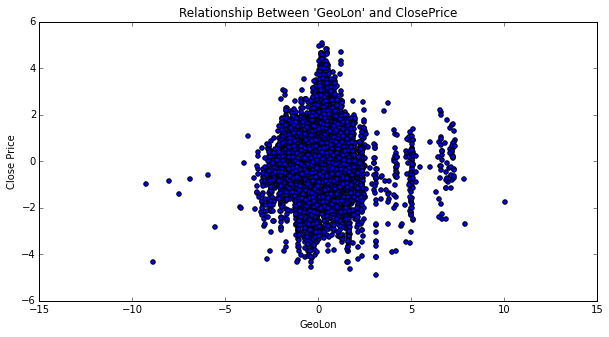

In [76]:
wanted = ['LivingArea', 'NumBedrooms','ExteriorStories','ListPrice','GeoLat','GeoLon','Month','Day','day_in_year','day_of_week']
for i in data:
    if i in wanted:
        plt.figure(figsize=(10,5))
        plt.scatter(data[i], data['ClosePrice'])
        plt.title('Relationship Between %r and ClosePrice'%i)
        plt.xlabel(i)
        plt.ylabel('Close Price')
        plt.show()

In [7]:
# Visualize Important Variables

# plt.hist(data['NumBedrooms'])
# plt.title('Number of Bedrooms')
# plt.xlabel('Number of Bedrooms')
# plt.ylabel('Number of Households')
# plt.show()


# for_price_visualization = data[(data['ListPrice'] < 500000)]
# plt.hist(np.array(for_price_visualization['ListPrice']))
# plt.title('List Price')
# plt.xlabel('List Price')
# plt.ylabel('Number of Households')
# plt.show()

# for_close_price_visualization = data[(data['ClosePrice'] < 500000)]
# plt.hist(np.array(for_close_price_visualization['ClosePrice'].dropna()))
# plt.title('Close Price')
# plt.xlabel('Close Price')
# plt.ylabel('Number of Households')
# plt.show()

In [89]:
# Look at linear relationship strength
data.corr()

,ListingId,LivingArea,NumBedrooms,NumBaths,ExteriorStories,ListPrice,GeoLat,GeoLon,ClosePrice,Both Private & Community,Community,None,Private,Active,Cancelled,Closed,Expired,Pending,Temp Off Market,Apartment Style/Flat,Gemini/Twin Home,Loft Style,Mfg/Mobile Housing,Modular/Pre-Fab,Patio Home,Single Family - Detached,Townhouse,ListDate month,ListDate day,ListDate day_of_week,ListPrice*Patio Home,Both Private & Community*Community,Community*Both Private & Community,None*None,Temp Off Market*Loft Style,Temp Off Market*Single Family - Detached,Loft Style*Temp Off Market,Patio Home*ListPrice,Patio Home*Patio Home,Single Family - Detached*Temp Off Market,LivingArea*ListPrice*Patio Home,LivingArea*None*None,LivingArea*Patio Home*ListPrice,LivingArea*Patio Home*Patio Home,NumBedrooms*ListPrice*Patio Home,NumBedrooms*None*None,NumBedrooms*Patio Home*ListPrice,NumBedrooms*Patio Home*Patio Home,NumBaths*Patio Home*Patio Home,ListPrice*ListPrice*Patio Home,ListPrice*Both Private & Community*Community,ListPrice*Community*Both Private & Community,ListPrice*None*None,ListPrice*Temp Off Market*Loft Style,ListPrice*Temp Off Market*Single Family - Detached,ListPrice*Loft Style*Temp Off Market,ListPrice*Patio Home*ListPrice,ListPrice*Patio Home*Patio Home,ListPrice*Single Family - Detached*Temp Off Market,Both Private & Community*ListPrice*Patio Home,Both Private & Community*None*None,Both Private & Community*Patio Home*ListPrice,Community*None*None,None*ListPrice*Patio Home,None*None*None,None*Patio Home*ListPrice,None*Patio Home*Patio Home,Temp Off Market*ListPrice*Patio Home,Temp Off Market*None*None,Temp Off Market*Patio Home*ListPrice,Loft Style*Temp Off Market*Single Family - Detached,Loft Style*Single Family - Detached*Temp Off Market,Patio Home*ListPrice*Patio Home,Patio Home*None*None,Patio Home*Patio Home*ListPrice,Patio Home*Patio Home*Patio Home,Single Family - Detached*ListPrice*Patio Home,Single Family - Detached*None*None,Single Family - Detached*Temp Off Market*Loft Style,Single Family - Detached*Loft Style*Temp Off Market,Single Family - Detached*Patio Home*ListPrice,ListPrice*Patio Home*LivingArea,ListPrice*Patio Home*NumBedrooms,ListPrice*Patio Home*Both Private & Community,ListPrice*Patio Home*None,ListPrice*Patio Home*Temp Off Market,ListPrice*Patio Home*Single Family - Detached,ListPrice*Patio Home*ListPrice*Patio Home,ListPrice*Patio Home*Both Private & Community*Community,ListPrice*Patio Home*Community*Both Private & Community,ListPrice*Patio Home*Temp Off Market*Loft Style,ListPrice*Patio Home*Temp Off Market*Single Family - Detached,ListPrice*Patio Home*Loft Style*Temp Off Market,ListPrice*Patio Home*Patio Home*ListPrice,ListPrice*Patio Home*Patio Home*Patio Home,ListPrice*Patio Home*Single Family - Detached*Temp Off Market,Both Private & Community*Community*ListPrice,Both Private & Community*Community*ListPrice*Patio Home,Both Private & Community*Community*None*None,Both Private & Community*Community*Patio Home*ListPrice,Both Private & Community*Community*Patio Home*Patio Home,Community*Both Private & Community*ListPrice,Community*Both Private & Community*ListPrice*Patio Home,Community*Both Private & Community*None*None,Community*Both Private & Community*Patio Home*ListPrice,Community*Both Private & Community*Patio Home*Patio Home,None*None*LivingArea,None*None*NumBedrooms,None*None*ListPrice,None*None*Both Private & Community,None*None*Community,None*None*Temp Off Market,None*None*Patio Home,None*None*Single Family - Detached,None*None*Both Private & Community*Community,None*None*Community*Both Private & Community,None*None*None*None,None*None*Temp Off Market*Single Family - Detached,None*None*Single Family - Detached*Temp Off Market,Temp Off Market*Loft Style*ListPrice,Temp Off Market*Loft Style*Single Family - Detached,Temp Off Market*Loft Style*ListPrice*Patio Home,Temp Off Market*Loft Style*Patio Home*ListPrice,Temp Off Market*Single Family - Detached*ListPrice,Temp Off Market*Single Family - Detached*Loft Style,T

In [91]:
data[:5]

,ListingId,LivingArea,NumBedrooms,NumBaths,ExteriorStories,ListPrice,GeoLat,GeoLon,ClosePrice,Both Private & Community,Community,None,Private,Active,Cancelled,Closed,Expired,Pending,Temp Off Market,Apartment Style/Flat,Gemini/Twin Home,Loft Style,Mfg/Mobile Housing,Modular/Pre-Fab,Patio Home,Single Family - Detached,Townhouse,ListDate month,ListDate day,ListDate day_of_week,ListPrice*Patio Home,Both Private & Community*Community,Community*Both Private & Community,None*None,Temp Off Market*Loft Style,Temp Off Market*Single Family - Detached,Loft Style*Temp Off Market,Patio Home*ListPrice,Patio Home*Patio Home,Single Family - Detached*Temp Off Market,LivingArea*ListPrice*Patio Home,LivingArea*None*None,LivingArea*Patio Home*ListPrice,LivingArea*Patio Home*Patio Home,NumBedrooms*ListPrice*Patio Home,NumBedrooms*None*None,NumBedrooms*Patio Home*ListPrice,NumBedrooms*Patio Home*Patio Home,NumBaths*Patio Home*Patio Home,ListPrice*ListPrice*Patio Home,ListPrice*Both Private & Community*Community,ListPrice*Community*Both Private & Community,ListPrice*None*None,ListPrice*Temp Off Market*Loft Style,ListPrice*Temp Off Market*Single Family - Detached,ListPrice*Loft Style*Temp Off Market,ListPrice*Patio Home*ListPrice,ListPrice*Patio Home*Patio Home,ListPrice*Single Family - Detached*Temp Off Market,Both Private & Community*ListPrice*Patio Home,Both Private & Community*None*None,Both Private & Community*Patio Home*ListPrice,Community*None*None,None*ListPrice*Patio Home,None*None*None,None*Patio Home*ListPrice,None*Patio Home*Patio Home,Temp Off Market*ListPrice*Patio Home,Temp Off Market*None*None,Temp Off Market*Patio Home*ListPrice,Loft Style*Temp Off Market*Single Family - Detached,Loft Style*Single Family - Detached*Temp Off Market,Patio Home*ListPrice*Patio Home,Patio Home*None*None,Patio Home*Patio Home*ListPrice,Patio Home*Patio Home*Patio Home,Single Family - Detached*ListPrice*Patio Home,Single Family - Detached*None*None,Single Family - Detached*Temp Off Market*Loft Style,Single Family - Detached*Loft Style*Temp Off Market,Single Family - Detached*Patio Home*ListPrice,ListPrice*Patio Home*LivingArea,ListPrice*Patio Home*NumBedrooms,ListPrice*Patio Home*Both Private & Community,ListPrice*Patio Home*None,ListPrice*Patio Home*Temp Off Market,ListPrice*Patio Home*Single Family - Detached,ListPrice*Patio Home*ListPrice*Patio Home,ListPrice*Patio Home*Both Private & Community*Community,ListPrice*Patio Home*Community*Both Private & Community,ListPrice*Patio Home*Temp Off Market*Loft Style,ListPrice*Patio Home*Temp Off Market*Single Family - Detached,ListPrice*Patio Home*Loft Style*Temp Off Market,ListPrice*Patio Home*Patio Home*ListPrice,ListPrice*Patio Home*Patio Home*Patio Home,ListPrice*Patio Home*Single Family - Detached*Temp Off Market,Both Private & Community*Community*ListPrice,Both Private & Community*Community*ListPrice*Patio Home,Both Private & Community*Community*None*None,Both Private & Community*Community*Patio Home*ListPrice,Both Private & Community*Community*Patio Home*Patio Home,Community*Both Private & Community*ListPrice,Community*Both Private & Community*ListPrice*Patio Home,Community*Both Private & Community*None*None,Community*Both Private & Community*Patio Home*ListPrice,Community*Both Private & Community*Patio Home*Patio Home,None*None*LivingArea,None*None*NumBedrooms,None*None*ListPrice,None*None*Both Private & Community,None*None*Community,None*None*Temp Off Market,None*None*Patio Home,None*None*Single Family - Detached,None*None*Both Private & Community*Community,None*None*Community*Both Private & Community,None*None*None*None,None*None*Temp Off Market*Single Family - Detached,None*None*Single Family - Detached*Temp Off Market,Temp Off Market*Loft Style*ListPrice,Temp Off Market*Loft Style*Single Family - Detached,Temp Off Market*Loft Style*ListPrice*Patio Home,Temp Off Market*Loft Style*Patio Home*ListPrice,Temp Off Market*Single Family - Detached*ListPrice,Temp Off Market*Single Family - Detached*Loft Style,T

In [90]:
test_data[:5]

,ListingId,LivingArea,NumBedrooms,NumBaths,ExteriorStories,ListPrice,GeoLat,GeoLon,ClosePrice,Both Private & Community,Community,None,Private,Active,Cancelled,Closed,Expired,Pending,Temp Off Market,Apartment Style/Flat,Gemini/Twin Home,Loft Style,Mfg/Mobile Housing,Modular/Pre-Fab,Patio Home,Single Family - Detached,Townhouse,ListDate month,ListDate day,ListDate day_of_week,ListPrice*Patio Home,Both Private & Community*Community,Community*Both Private & Community,None*None,Temp Off Market*Loft Style,Temp Off Market*Single Family - Detached,Loft Style*Temp Off Market,Patio Home*ListPrice,Patio Home*Patio Home,Single Family - Detached*Temp Off Market,LivingArea*ListPrice*Patio Home,LivingArea*None*None,LivingArea*Patio Home*ListPrice,LivingArea*Patio Home*Patio Home,NumBedrooms*ListPrice*Patio Home,NumBedrooms*None*None,NumBedrooms*Patio Home*ListPrice,NumBedrooms*Patio Home*Patio Home,NumBaths*Patio Home*Patio Home,ListPrice*ListPrice*Patio Home,ListPrice*Both Private & Community*Community,ListPrice*Community*Both Private & Community,ListPrice*None*None,ListPrice*Temp Off Market*Loft Style,ListPrice*Temp Off Market*Single Family - Detached,ListPrice*Loft Style*Temp Off Market,ListPrice*Patio Home*ListPrice,ListPrice*Patio Home*Patio Home,ListPrice*Single Family - Detached*Temp Off Market,Both Private & Community*ListPrice*Patio Home,Both Private & Community*None*None,Both Private & Community*Patio Home*ListPrice,Community*None*None,None*ListPrice*Patio Home,None*None*None,None*Patio Home*ListPrice,None*Patio Home*Patio Home,Temp Off Market*ListPrice*Patio Home,Temp Off Market*None*None,Temp Off Market*Patio Home*ListPrice,Loft Style*Temp Off Market*Single Family - Detached,Loft Style*Single Family - Detached*Temp Off Market,Patio Home*ListPrice*Patio Home,Patio Home*None*None,Patio Home*Patio Home*ListPrice,Patio Home*Patio Home*Patio Home,Single Family - Detached*ListPrice*Patio Home,Single Family - Detached*None*None,Single Family - Detached*Temp Off Market*Loft Style,Single Family - Detached*Loft Style*Temp Off Market,Single Family - Detached*Patio Home*ListPrice,ListPrice*Patio Home*LivingArea,ListPrice*Patio Home*NumBedrooms,ListPrice*Patio Home*Both Private & Community,ListPrice*Patio Home*None,ListPrice*Patio Home*Temp Off Market,ListPrice*Patio Home*Single Family - Detached,ListPrice*Patio Home*ListPrice*Patio Home,ListPrice*Patio Home*Both Private & Community*Community,ListPrice*Patio Home*Community*Both Private & Community,ListPrice*Patio Home*Temp Off Market*Loft Style,ListPrice*Patio Home*Temp Off Market*Single Family - Detached,ListPrice*Patio Home*Loft Style*Temp Off Market,ListPrice*Patio Home*Patio Home*ListPrice,ListPrice*Patio Home*Patio Home*Patio Home,ListPrice*Patio Home*Single Family - Detached*Temp Off Market,Both Private & Community*Community*ListPrice,Both Private & Community*Community*ListPrice*Patio Home,Both Private & Community*Community*None*None,Both Private & Community*Community*Patio Home*ListPrice,Both Private & Community*Community*Patio Home*Patio Home,Community*Both Private & Community*ListPrice,Community*Both Private & Community*ListPrice*Patio Home,Community*Both Private & Community*None*None,Community*Both Private & Community*Patio Home*ListPrice,Community*Both Private & Community*Patio Home*Patio Home,None*None*LivingArea,None*None*NumBedrooms,None*None*ListPrice,None*None*Both Private & Community,None*None*Community,None*None*Temp Off Market,None*None*Patio Home,None*None*Single Family - Detached,None*None*Both Private & Community*Community,None*None*Community*Both Private & Community,None*None*None*None,None*None*Temp Off Market*Single Family - Detached,None*None*Single Family - Detached*Temp Off Market,Temp Off Market*Loft Style*ListPrice,Temp Off Market*Loft Style*Single Family - Detached,Temp Off Market*Loft Style*ListPrice*Patio Home,Temp Off Market*Loft Style*Patio Home*ListPrice,Temp Off Market*Single Family - Detached*ListPrice,Temp Off Market*Single Family - Detached*Loft Style,T

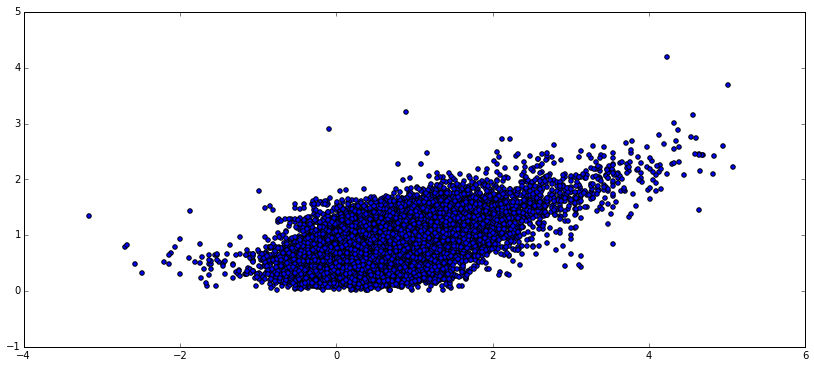

In [58]:
list(data.columns)

['ListingId',
 'LivingArea',
 'NumBedrooms',
 'NumBaths',
 'ExteriorStories',
 'ListPrice',
 'GeoLat',
 'GeoLon',
 'ClosePrice',
 'Both Private & Community',
 'Community',
 'None',
 'Private',
 'Active',
 'Cancelled',
 'Closed',
 'Expired',
 'Pending',
 'Temp Off Market',
 'Apartment Style/Flat',
 'Gemini/Twin Home',
 'Loft Style',
 'Mfg/Mobile Housing',
 'Modular/Pre-Fab',
 'Patio Home',
 'Single Family - Detached',
 'Townhouse',
 'ListDate month',
 'ListDate day',
 'ListDate day_of_week',
 'ListPrice*ListPrice',
 'ListPrice*Single Family - Detached',
 'Community*None',
 'None*Community',
 'Private*Private',
 'Apartment Style/Flat*Mfg/Mobile Housing',
 'Apartment Style/Flat*Townhouse',
 'Mfg/Mobile Housing*Apartment Style/Flat',
 'Mfg/Mobile Housing*Townhouse',
 'Single Family - Detached*ListPrice',
 'Single Family - Detached*Single Family - Detached',
 'Townhouse*Apartment Style/Flat',
 'Townhouse*Mfg/Mobile Housing']

In [79]:
adjusted_y_test = unprocess(y_test)

In [101]:

print abs(bayesian_unprocessed-adjusted_y_test).mean()
print np.median(abs(adjusted-adjusted_y_test))

ValueError: shapes (707,27) and (26,) not aligned: 27 (dim 1) != 26 (dim 0)

In [81]:

print abs(bayesian_unprocessed_stacking-unprocess(y_train_training)).mean()
print np.median(abs(bayesian_unprocessed_stacking-unprocess(y_train_training)))

5192.96055476
3610.08361931


/Users/jeremynixon/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/jeremynixon/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app


In [84]:
print x_train_training.shape
print x_test_listprice.shape

(17321, 27)
(707, 27)


4809.59319129
3423.95888114


In [95]:
forest = ensemble.RandomForestRegressor(n_estimators = 1000)
forest.fit(x_train_training, y_train_training)
forest_predictions = forest.predict(x_test_listprice)
print abs(unprocess(forest_predictions)-unprocess(y_test)).mean()
print np.median(abs(unprocess(forest_predictions)-unprocess(y_test)))

4929.15434147
3762.56636322


In [98]:
bayesian_ridge = linear_model.BayesianRidge()
bayesian_ridge.fit(x_train_training, y_train_training)
bayesian_ridge_predictions = bayesian_ridge.predict(x_test_listprice)
print abs(unprocess(bayesian_ridge_predictions)-unprocess(y_test)).mean()
print np.median(abs(unprocess(bayesian_ridge_predictions)-unprocess(y_test)))

4770.12063132
3505.56227269


In [62]:
import pandas as pd
import numpy as np
import zipfile
import matplotlib.pyplot as plt
from sklearn import ensemble
from sklearn import linear_model
from sklearn import svm
%matplotlib inline
from collections import Counter
import sklearn.cross_validation
import math
import time
pd.set_option('display.max_columns', None)
from scipy import stats
from sklearn.linear_model import RandomizedLasso
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
#from sklearn.pls import PLSRegression
import sys

def model_suite(x_train, y_train, x_test, y_test):
    predictions = []
    
    lasso = linear_model.Lasso()
    lasso.fit(x_train, y_train)
    predictions.append(['Lasso', lasso.predict(x_test)])
    print 'Lasso Complete.'
    sys.stdout.flush()
    
    elastic = linear_model.ElasticNet()
    elastic.fit(x_train, y_train)
    predictions.append(['Elastic Net', elastic.predict(x_test)]) 
    print 'Elastic Net Complete.'
    sys.stdout.flush()
    
    ridge = linear_model.Ridge()
    ridge.fit(x_train, y_train)
    predictions.append(['Ridge Regression', ridge.predict(x_test)]) 
    print 'Ridge Regression Complete.'
    sys.stdout.flush()
    
    bayesian_ridge = linear_model.BayesianRidge()
    bayesian_ridge.fit(x_train, y_train)
    predictions.append(['Bayesian Ridge', bayesian_ridge.predict(x_test)])
    print 'Bayesian Ridge Regression Complete.'
    sys.stdout.flush()
    
#     pls = PLSRegression(n_components=3)
#     pls.fit(x_train, y_train)
#     pls_predictions = pls.predict(x_test)
#     pls_predictions = pls_predictions.reshape(len(pls_predictions),)
#     predictions.append(['Partial Least Squares', pls_predictions])
#     print 'Partial Least Squares Regression Complete.'
#     sys.stdout.flush()
    
#     svr_rbf = svm.SVR(kernel = 'rbf')
#     svr_rbf.fit(x_train, y_train)
#     predictions.append(['SVR rbf', svr_rbf.predict(x_test)])
#     print 'Support Vector Regressor RBF Kernel Complete.'
#     sys.stdout.flush()
    
#     svr_linear = svm.SVR(kernel = 'linear')
#     svr_linear.fit(x_train, y_train)
#     predictions.append(['SVR linear', svr_linear.predict(x_test)])
#     print 'Support Vector Regressor Linear Kernel Complete.'
#     sys.stdout.flush()
    
#     svr_poly = svm.SVR(kernel = 'poly')
#     svr_poly.fit(x_train, y_train)
#     predictions.append(['SVR poly', svr_poly.predict(x_test)])
#     print 'Support Vector Regressor Poly Kernel Complete.'
#     sys.stdout.flush()
    
    forest = ensemble.RandomForestRegressor(n_estimators = 100)
    forest.fit(x_train, y_train)
    predictions.append(['Forest', forest.predict(x_test)]) 
    print 'Random Forest Regressor Complete.'
    sys.stdout.flush()

    extra = ensemble.ExtraTreesRegressor(n_estimators=100)
    extra.fit(x_train, y_train)
    predictions.append(['Extremely Random Forest', extra.predict(x_test)])
    print 'Extremely Random Forest Complete.'
    sys.stdout.flush()
    
    booster = ensemble.GradientBoostingRegressor(n_estimators = 100)
    booster.fit(x_train, y_train)
    predictions.append(['Booster', booster.predict(x_test)])
    print 'Gradient Boosted Trees Complete.'
    sys.stdout.flush()
    
    return predictions
start = time.time()
predictions = model_suite(x_train_stacking, y_train_stacking, x_test_listprice, y_test)
print time.time()-start

Lasso Complete.
Elastic Net Complete.
Ridge Regression Complete.
Bayesian Ridge Regression Complete.
Random Forest Regressor Complete.
Extremely Random Forest Complete.
Gradient Boosted Trees Complete.
25.0848441124


In [63]:
adjusted_y_test = unprocess(y_test)
for i in range(len(predictions)):
    print predictions[i][0]
    adjusted = unprocess(predictions[i][1])
    print "%r MAE = %r" %(predictions[i][0], abs(adjusted-adjusted_y_test).mean())
    print "%r Median = %r" %(predictions[i][0], np.median(abs(adjusted-adjusted_y_test)))

Lasso
'Lasso' MAE = 75561.111561611324
'Lasso' Median = 58184.425188226654
Elastic Net
'Elastic Net' MAE = 51160.796150784852
'Elastic Net' Median = 37164.265981831821
Ridge Regression
'Ridge Regression' MAE = 4788.252270884429
'Ridge Regression' Median = 3471.926441506861
Bayesian Ridge
'Bayesian Ridge' MAE = 4787.9787813573603
'Bayesian Ridge' Median = 3466.0989050729841
Forest
'Forest' MAE = 5126.9037005005066
'Forest' Median = 3829.3826181655168
Extremely Random Forest
'Extremely Random Forest' MAE = 5654.123315967372
'Extremely Random Forest' Median = 3923.3535126872885
Booster
'Booster' MAE = 4760.746419172654
'Booster' Median = 3466.7994923970255


In [351]:
ensemble = ['Ridge Regression','Bayesian Ridge']
count = 0
combined_predictions = [0]*len(predictions[0][1])
for i in range(len(predictions)):
    if predictions[i][0] in ensemble:
        count += 1
        combined_predictions += predictions[i][1]
final_predictions = combined_predictions/count
final_predictions = unprocess(final_predictions)
adjusted = final_predictions
print abs(adjusted-adjusted_y_test).mean()
print np.median(abs(adjusted-adjusted_y_test))

5139.29008841
3479.08787996


In [352]:
ensemble = ['Bayesian Ridge', 'Booster']
count = 0
combined_predictions = [0]*len(predictions[0][1])
for i in range(len(predictions)):
    if predictions[i][0] in ensemble:
        count += 1
        combined_predictions += predictions[i][1]
final_predictions = combined_predictions/count
final_predictions = unprocess(final_predictions)
adjusted = final_predictions
print abs(adjusted-adjusted_y_test).mean()
print np.median(abs(adjusted-adjusted_y_test))

11870.2176264
4835.25732526


In [301]:
svr = svm.SVR(kernel = rbf)
svr.fit(x_train_listprice, y_train)
svr_predictions = svr.predict(x_test_listprice)

In [302]:
adjusted_svr_predictions = unprocess(svr_predictions)
print abs(adjusted_svr_predictions-adjusted_y_test).mean()
print np.median(abs(adjusted_svr_predictions-adjusted_y_test))

76394.4146828
65035.7129826


In [298]:
pls = PLSRegression(n_components=5)
pls.fit(x_train_listprice, y_train)
pls_predictions = pls.predict(x_test_listprice)
pls_predictions = pls_predictions.reshape(len(pls_predictions),)
adjusted_pls_predictions = unprocess(pls_predictions)
print abs(adjusted_pls_predictions-adjusted_y_test).mean()
print np.median(abs(adjusted_pls_predictions-adjusted_y_test))

76654.4455513
58454.6164124


In [211]:
lasso = linear_model.Lasso()
lasso.fit(x_train_listprice, y_train)
lasso_predictions = lasso.predict(x_test_listprice)
adjusted_lasso_predictions = unprocess(lasso_predictions)
print abs(adjusted_lasso_predictions-adjusted_y_test).mean()
print np.median(abs(adjusted_lasso_predictions-adjusted_y_test))

76058.1575217
58911.0595624


In [212]:
elastic = linear_model.ElasticNet()
elastic.fit(x_train_listprice, y_train)
elastic_predictions = elastic.predict(x_test_listprice)
adjusted_elastic_predictions = unprocess(elastic_predictions)
print abs(adjusted_elastic_predictions-adjusted_y_test).mean()
print np.median(abs(adjusted_elastic_predictions-adjusted_y_test))

51842.2903295
37481.8890476


In [ ]:
ridge = linear_model.Ridge()
ridge.fit(x_train_listprice, y_train)
ridge_predictions = ridge.predict(x_test_listprice)

In [ ]:
adjusted_ridge_predictions = unprocess(ridge_predictions)
print abs(adjusted_ridge_predictions-adjusted_y_test).mean()
print np.median(abs(adjusted_ridge_predictions-adjusted_y_test))

In [245]:
bayesian_ridge = linear_model.BayesianRidge()
bayesian_ridge.fit(x_train_listprice, y_train)
bayesian_ridge_predictions = bayesian_ridge.predict(x_test_listprice)

In [246]:
adjusted_bayesian_ridge_predictions = unprocess(bayesian_ridge_predictions)
print abs(adjusted_bayesian_ridge_predictions-adjusted_y_test).mean()
print np.median(abs(adjusted_bayesian_ridge_predictions-adjusted_y_test))

5139.34580862
3477.86791424


In [239]:
forest = ensemble.RandomForestRegressor(n_estimators = 1000)
forest.fit(x_train_listprice, y_train)
forest_predictions = forest.predict(x_test_listprice)

In [240]:
adjusted_forest_predictions = unprocess(forest_predictions)
adjusted_y_test = unprocess(y_test)
print abs(adjusted_forest_predictions-adjusted_y_test).mean()
print np.median(abs(adjusted_forest_predictions-adjusted_y_test))

5346.48582407
3667.61869624


In [336]:
booster = ensemble.GradientBoostingRegressor(n_estimators = 1000)
booster.fit(x_train_listprice, y_train)
booster_predictions = booster.predict(x_test_listprice)

In [337]:
adjusted_booster_predictions = unprocess(booster_predictions)
adjusted_y_test = unprocess(y_test)
print abs(adjusted_booster_predictions-adjusted_y_test).mean()
print np.median(abs(adjusted_booster_predictions-adjusted_y_test))

18574.8960158
6529.11654517


In [162]:
rlasso = RandomizedLasso(alpha=0.025)
rlasso.fit(x_train, y_train)

RandomizedLasso(alpha=0.025, eps=2.2204460492503131e-16, fit_intercept=True,
        max_iter=500, memory=Memory(cachedir=None), n_jobs=1,
        n_resampling=200, normalize=True, pre_dispatch='3*n_jobs',
        precompute='auto', random_state=None, sample_fraction=0.75,
        scaling=0.5, selection_threshold=0.25, verbose=False)

In [168]:
lr = LinearRegression()
rfe = RFE(lr, n_features_to_select=1)
rfe.fit(x_train,y_train)

RFE(estimator=LinearRegression(copy_X=True, fit_intercept=True, normalize=False),
  estimator_params={}, n_features_to_select=1, step=1, verbose=0)

In [172]:
for i in range(len(rfe.ranking_)):
    print(x_train.columns[i],list(rfe.ranking_)[i])

('LivingArea', 7)
('NumBedrooms', 5)
('NumBaths', 18)
('ExteriorStories', 20)
('ListPrice', 3)
('GeoLat', 14)
('GeoLon', 13)
('Both Private & Community', 11)
('Private', 6)
('Apartment Style/Flat', 21)
('Gemini/Twin Home', 19)
('Single Family - Detached', 16)
('Townhouse', 22)
('Both Private & Community*Community', 10)
('Community*Both Private & Community', 15)
('None*None', 17)
('Temp Off Market*Loft Style', 1)
('Temp Off Market*Single Family - Detached', 9)
('Loft Style*Temp Off Market', 2)
('Patio Home*ListPrice', 4)
('Patio Home*Patio Home', 12)
('Single Family - Detached*Temp Off Market', 8)


In [229]:
for i in range(len(forest.feature_importances_)):
    print(x_train_listprice.columns[i],list(forest.feature_importances_)[i])

('LivingArea', 0.0016794835184023218)
('NumBedrooms', 0.00028543326856058764)
('NumBaths', 0.0003548798890229264)
('ExteriorStories', 0.00013923075186613384)
('ListPrice', 0.99156155707467986)
('GeoLat', 0.0016258250549617372)
('GeoLon', 0.0018161923523261764)
('Both Private & Community', 5.5995243396190343e-05)
('Private', 4.5959293321998436e-05)
('Apartment Style/Flat', 2.2598568058683645e-05)
('Gemini/Twin Home', 6.3889358775157266e-06)
('Single Family - Detached', 3.2298257241907193e-05)
('Townhouse', 0.00055943204042675039)
('Both Private & Community*Community', 8.8784374684049041e-05)
('Community*Both Private & Community', 9.1317223046607016e-05)
('None*None', 0.00011989040825071763)
('Temp Off Market*Loft Style', 5.8968786406275096e-05)
('Temp Off Market*Single Family - Detached', 3.2179062238205669e-05)
('Loft Style*Temp Off Market', 5.3846630405726995e-05)
('Patio Home*ListPrice', 0.0013003452780402777)
('Patio Home*Patio Home', 3.858882361113285e-05)
('Single Family - Detache

5377.14132625
3611.20589043


In [193]:
print np.median(abs(adjusted_forest_predictions-adjusted_y_test))
print np.median(abs(adjusted_ridge_predictions-adjusted_y_test))
print np.median(abs((adjusted_forest_predictions+adjusted_ridge_predictions)/2-adjusted_y_test))

3911.10754857
3779.08285951
3796.36110351


In [146]:
for i in forest.feature_importances_:
    print i

0.623263623317
0.00814109778465
0.0108514511285
0.0236653735422
0.156256255746
0.126733843561
0.00151671130924
0.000151702515992
0.00020132781808
0.000286547295372
0.00115117901233
0.00839686835135
0.0036798290262
0.00355271613797
0.00144649943541
0.00635654290399
0.00143443569965
0.00629092441092
0.0153064157583
0.00131665524559


In [115]:
adjusted_predictions

array([  63937.45641274,  307002.73142906,  184008.36639227, ...,
        256483.54648971,  126221.16862919,  196477.73798666])

In [20]:
predictions = (forest_predictions + booster_predictions)/2

In [98]:
# Root Mean Squared Error
def RMSE(predictions, actual):
    squared_error = (predictions - actual)**2
    MSE = squared_error.mean()
    RMSE = math.sqrt(MSE)
    return RMSE

In [99]:
# Mean Absolute Error
def MAE(predictions, actual):
    MAE = (abs(predictions-y_test).mean())
    return MAE

In [60]:
adjusted_predictions

array([  56973.69187771,  305985.90026957,  184035.80643408, ...,
        254991.16701862,  126000.04222908,  188786.45268643])

In [108]:
# With all combined features
#abs(adjusted_predictions-adjusted_y_test).mean()

6637.0483540219757

In [116]:
abs(adjusted_predictions-adjusted_y_test).mean()

6638.8873937832859

In [109]:
RMSE(adjusted_predictions, adjusted_y_test)

13363.227024125488

In [34]:
# Median Error
error_array = abs(predictions-y_test)
error_array.sort()
error_array[len(error_array)/2]

3702.9739825716242

In [68]:
1-((abs(adjusted_predictions-adjusted_y_test).mean())/adjusted_y_test.mean())

0.99881719362881494

In [24]:
R2 = pd.Series(predictions).corr(pd.Series(y_test))**2
R2

0.9949565676120592

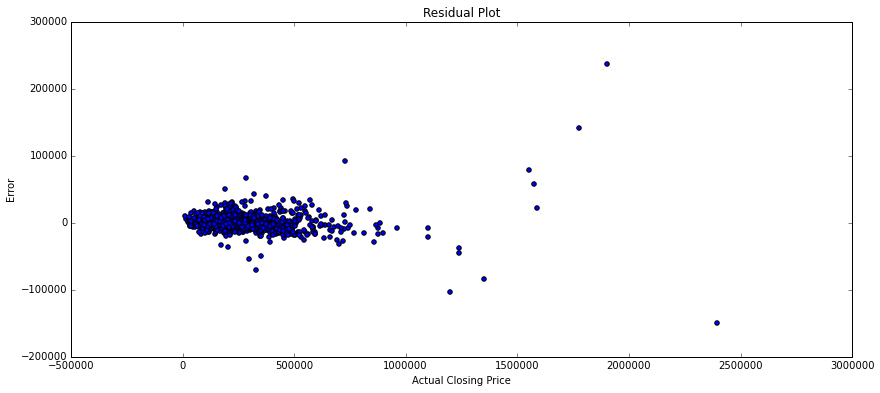

In [37]:
# Errors
plt.figure(figsize = (14, 6))
plt.scatter(y_test, predictions-y_test)
plt.title('Residual Plot')
plt.xlabel('Actual Closing Price')
plt.ylabel('Error')

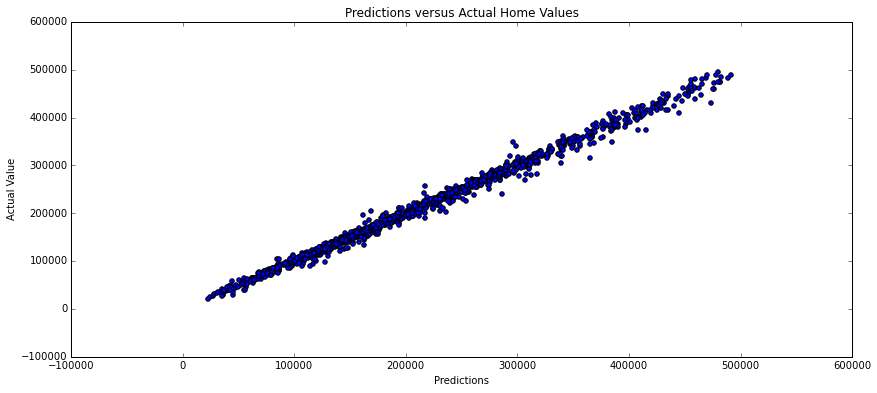

In [260]:
# Visualize Predictions

plt.figure(figsize = (14, 6))
plt.scatter(adjusted_booster_predictions, adjusted_y_test)
plt.title('Predictions versus Actual Home Values')
plt.xlabel('Predictions')
plt.ylabel('Actual Value')